<a href="https://colab.research.google.com/github/tibernard/AI/blob/master/SearchDestroy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

found 87 in  1


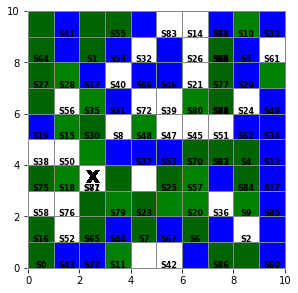

In [0]:
import numpy as np
import copy
from itertools import product
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
from collections import deque
import random


class SearchDestroy(object):
    covered_color = '#DDDDDD'
    uncovered_color = '#AAAAAA'
    edge_color = '#888888'
    count_colors = ['green','white', 'blue','darkgreen', 'red', 'darkblue',
                    'darkred', 'black', 'black']
    flag_vertices = np.array([[0.25, 0.2], [0.25, 0.8],
                              [0.75, 0.65], [0.25, 0.5]])


      
         
      
    def __init__(self, width, height):
        self.width, self.height = width, height

        # Create the figure and axes
        self.fig = plt.figure(figsize=((width + 2) / 3., (height + 2) / 3.))
        
        
        
        self.ax = self.fig.add_axes((0.05, 0.05, 0.9, 0.9),
                                    aspect='equal', frameon=False,
                                    xlim=(-0.05, width + 0.05),
                                    ylim=(-0.05, height + 0.05))

        # Create the grid of squares
        self.squares = np.array([[RegularPolygon((i + 0.5, j + 0.5),
                                                 numVertices=4,
                                                 radius=0.5 * np.sqrt(2),
                                                 orientation=np.pi / 4,
                                                 ec=self.edge_color,
                                                 fc=self.covered_color)
                                  for j in range(height)]
                                 for i in range(width)])
        [self.ax.add_patch(sq) for sq in self.squares.flat]
        
        #randomly assign each cell a terrain type
        self.flat=0.2
        self.hilly=0.3
        self.forested=0.3
        self.caves=0.2
        

        self.target = np.zeros((self.width, self.height), dtype=object)
        self.belief = np.zeros((self.width, self.height), dtype=float)
        self.posterior = np.zeros((self.width, self.height), dtype=float)
        
        
        self.landscapes=np.random.choice([0,1,2,3], p=[self.flat,self.hilly,self.forested,self.caves], size=(self.width, self.height))
        # Place the target randomly
        self.SetTarget()
        self.cur_cell_x=0
        self.cur_cell_y=0
        self.interations=0

    def SetTarget(self):
      self.target = np.zeros((self.width, self.height), dtype=object)
      i,j=self.random_cell()
      self.target[i][j]=True

    #Function to distribute the color of land according to their distribution in the landscapes matrice
    def RefreshBoard(self):
      for i in range(self.width):
          for j in range(self.height):
            self.squares[i][j].set_fc(self.count_colors[self.landscapes[i][j]])
      #Coordinate of the target is returned
      x,y=self.get_target()
      #Put an X in the map at the same coordinate of of the target 
      self.ax.text(x + 0.5, y + 0.5, str("X"),
                 color=self.count_colors[7],
                 ha='center', va='center', fontsize=18,
                 fontweight='bold')
      x,y=self.cur_cell_x,self.cur_cell_y
      # Place the later S in the current the agent is searching
      self.ax.text(x + 0.5, y+0.1, "S"+str(self.interations),
                 color=self.count_colors[7],
                 ha='center', va='center', fontsize=8,
                 fontweight='bold')

      
    #Return the target coordinates
    def get_target(self):
      for x in range(self.width):
        for y in range(self.height):
          if self.target[x][y]:
            return (x,y)
    #Return a random cell that can be used to place the target 
    def random_cell(self):
      op=[]
      for x in range(self.width):
        for y in range(self.height):
          op.append((x,y))
      a = np.arange(len(op))
      np.random.shuffle(a)
      return op[a[0]]



    #P (Target not found in Celli|Target is in Celli)
    def FalseNegative(self,_indice):
      if _indice ==0: #flat
        return 0.1
      elif _indice==1: #hilly
        return 0.3
      elif _indice==2: #forested
        return 0.7
      else: #caves
        return 0.9

    #Compute the manhattan distance given cells' coordinates
    def M_distance(self, x, y, z, w):
      return abs(x-z) + abs(y-w)   
    #This function for pairs of cells' coordinates is checking wheter or not a cell is in the neigbours of 
    #the current cell we were searching for
    def is_neighbors(self,i,j,k,l):
      for n in range(-1,2):
        for r in range(-1,2):
          if r==0 and n==0: continue
          if (i+n==-1 or j+r==-1) or (i+n==j+r) or (i+n>self.width-1 or j+r>self.height-1): continue
          if i+n==k and j+r==l:
            return 1
      return 0

    # This function compute the utility matrice by reducing the probability in the belief matrice 
    # with the cost(penality, distance from current cell to cell[i,j]).
    #Cell in the neigbors of current cell are not penalized (free travel)
    def compute_utility(self,utility,A):
      cost=0
      for i in range (self.width):
        for j in range (self.height):
          cost=0
          if self.is_neighbors(self.cur_cell_x,self.cur_cell_y,i,j)==1:
            utility[i][j]=A[i][j] #Free cost because it is in the neighbour(No travel)
          else:
            cost =self.M_distance(self.cur_cell_x,self.cur_cell_y,i,j)
            if cost ==0: cost =1 #cell it self (No travel)
            utility[i][j]=A[i][j]/cost #Pnealize the probability of cell in term of distance travelled
      return utility

    # This function is selecting the next cell based on highest probaility in belief or prior matrice
    # in case of cost, the utility matrice is used to choose the highest probility redcued by the penality
    def NextCell(self,A=None,istravel=0):
      from numpy import unravel_index
      utility = np.zeros((self.width, self.height), dtype=float)
      if istravel==1:
        utility=self.compute_utility(utility,A)
        k,l= unravel_index(utility.argmax(), utility.shape)
      else:
        k,l= unravel_index(A.argmax(), A.shape)
      op=[]
      #Random cell is choosed in cas of many cells with same highest probability
      for x in range(self.width):
        for y in range(self.height):
          if A[x][y]==A[k][l]:
            op.append((x,y))
      a = np.arange(len(op))
      np.random.shuffle(a)
      #self.cur_cell_x,self.cur_cell_y
      #is_neighbors(self,i,j,k,l)
      return op[a[0]]

    #Make the probability in the matrice to have the same denominator (same scale)
    def Normalization(self,Vect=None):
       Total_prob = np.sum(Vect)
       return Vect/Total_prob
    #Compute the posterior matrice with the updated belief and (1-false negative)
    def Infere_posterior(self,Vect=None):
      for i in range(self.width):
        for j in range(self.height):
          Vect[i][j] =self.belief[i][j]*(1-self.FalseNegative(self.landscapes[i][j]) )
      return Vect

  

    def Agent(self,Rule="rule1",utility=0):
      inter=0
      self.interations=0
      for i in range(self.width):
        for j in range(self.height):
          self.belief[i][j]= 1/(self.width*self.height)
          self.posterior[i][j]= 1/(self.width*self.height)

      while True:
        #Variable to compute the interations until the agent finds the target
        inter=inter+1
        #Select the rule to be used (Rule 1->Belief,Rule 2->posterior)
        #Utility varible when its value is 1 means the cost(distance incorporated in the decison of next cell)
        self.interations=inter
        if Rule=="rule1":
          k,l=self.NextCell(self.belief,utility)
        elif Rule=="rule2":
          k,l=self.NextCell(self.posterior,utility)
        else:
          p=None
        #Coordinates of next cell
        self.cur_cell_x,self.cur_cell_y=k,l
        self.RefreshBoard()
        #print(self.belief)
        if self.target[k][l]==True:
          termination=random.uniform(0, 1)
          if termination > self.FalseNegative(self.landscapes[k][l]):
            print("found",inter,"in ",self.landscapes[k][l])
            return
        else:
          # prior belief current cel and normalization
          self.belief[k][l] *= self.FalseNegative(self.landscapes[k][l])
          self.belief=self.Normalization(self.belief)
          #Infere Posterior Belief and normalization
          self.posterior = self.Infere_posterior(self.posterior) 
          self.posterior  = self.Normalization(self.posterior)
                      

if __name__ == '__main__':
      ms=SearchDestroy(10, 10)
      ms.RefreshBoard()
      utility=1 #(0 is no and 1 is yes)
      ms.Agent("rule1",utility)
       
      


In [0]:
if __name__ == '__main__':
      rule1_iterations=[]
      rule2_iterations=[]
      terrain=["flat","hilly","forested","caves"]
      dim=7
      interat=0
      ms=SearchDestroy(dim, dim)
      ms.RefreshBoard()
      while interat<20:
        k,l=ms.get_target()
        land=terrain[ms.landscapes[k][l]]
        ms.Agent("rule1")
        rule1_iterations.append((land,ms.interations))
        ms.Agent("rule2")
        rule2_iterations.append((land,ms.interations))
        #ms=SearchDestroy(dim, dim)
        #ms.RefreshBoard()
        ms.SetTarget()
        interat=interat+1

found 52 in  1
found 28 in  1
found 33 in  1
found 25 in  1
found 40 in  1
found 23 in  1
found 12 in  1
found 13 in  1
found 44 in  1
found 19 in  1
found 53 in  2
found 41 in  2
found 46 in  1
found 14 in  1
found 48 in  0
found 2 in  0
found 39 in  1
found 30 in  1
found 48 in  2
found 43 in  2
found 35 in  0
found 11 in  0
found 58 in  3
found 100 in  3
found 47 in  3
found 105 in  3
found 78 in  3
found 104 in  3
found 50 in  1
found 27 in  1
found 47 in  2
found 43 in  2
found 20 in  0
found 7 in  0
found 56 in  2
found 43 in  2
found 31 in  0
found 1 in  0
found 15 in  0
found 8 in  0


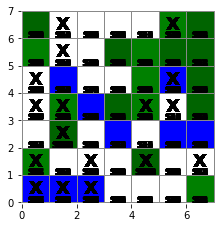

In [0]:
#To generate the chart we collect data(iterations) of rules on 20 samples of map fixed (7x7)
if __name__ == '__main__':
      rule1_iterations=[]
      rule2_iterations=[]
      terrain=["flat","hilly","forested","caves"]
      dim=7
      interat=0
      ms=SearchDestroy(dim, dim)
      ms.RefreshBoard()
      while interat<20:
        k,l=ms.get_target()
        land=terrain[ms.landscapes[k][l]]
        ms.Agent("rule1")
        rule1_iterations.append((land,ms.interations))
        ms.Agent("rule2")
        rule2_iterations.append((land,ms.interations))
        #ms=SearchDestroy(dim, dim)
        #ms.RefreshBoard()
        ms.SetTarget()
        interat=interat+1





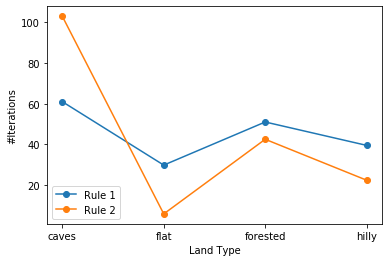

In [0]:
#Plot the different interactions for each rule with respect to the land type
#To show their performance
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(rule1_iterations)
df = pd.DataFrame(columns=['rule', 'land','iteration'])
for i in range (len(rule1_iterations)):
  listOfSeries = [pd.Series(["rule1",str(rule1_iterations[i][0]),int(rule1_iterations[i][1])], index=df.columns ) ]
  df = df.append(listOfSeries , ignore_index=True)
  listOfSeries = [pd.Series(["rule2",str(rule2_iterations[i][0]),int(rule2_iterations[i][1])], index=df.columns ) ]
  df = df.append(listOfSeries , ignore_index=True)
      # Pass a list of series to the append() to add multiple rows
df['iteration'] = df['iteration'].astype(int)
rule1_df = df[df['rule'] == "rule1"]
rule2_df = df[df['rule'] == "rule2"]
rule1_df=rule1_df['iteration'].groupby([rule1_df['land']]).mean().to_frame(name='mean').reset_index()
rule2_df=rule2_df['iteration'].groupby([rule2_df['land']]).mean().to_frame(name='mean').reset_index()
plt.plot(rule1_df["land"], rule1_df["mean"], marker = 'o', label = "Rule 1")
plt.plot(rule2_df["land"], rule2_df["mean"], marker = 'o', label = "Rule 2")
      
plt.xlabel("Land Type")
plt.ylabel("#Iterations")
plt.legend(['Rule 1', 'Rule 2'], loc='lower left')
plt.show()
plt.close()

found 24 in  2
found 21 in  2
found 13 in  2
found 28 in  2
found 34 in  2
found 12 in  2
found 14 in  2
found 19 in  2
found 19 in  2
found 37 in  2
found 33 in  3
found 69 in  3
found 3 in  0
found 5 in  0
found 27 in  2
found 13 in  2
found 11 in  1
found 9 in  1
found 20 in  2
found 1 in  2
found 36 in  3
found 74 in  3
found 6 in  0
found 4 in  0
found 30 in  2
found 14 in  2
found 20 in  2
found 20 in  2
found 19 in  0
found 2 in  0
found 27 in  2
found 13 in  2
found 20 in  1
found 1 in  1
found 25 in  3
found 82 in  3
found 18 in  2
found 26 in  2
found 18 in  2
found 20 in  2
found 27 in  2
found 16 in  2
found 31 in  2
found 23 in  2
found 6 in  3
found 69 in  3
found 2 in  0
found 7 in  0
found 24 in  2
found 17 in  2
found 27 in  3
found 81 in  3
found 32 in  3
found 67 in  3
found 27 in  2
found 24 in  2
found 24 in  2
found 22 in  2
found 24 in  2
found 23 in  2
found 31 in  3
found 73 in  3
found 29 in  2
found 13 in  2
found 27 in  2
found 27 in  2
found 35 in  3
found 

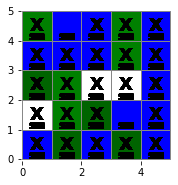

In [0]:
if __name__ == '__main__':
      rule1_iterations=[]
      rule2_iterations=[]
      terrain=["flat","hilly","forested","caves"]
      dim=5
      interat=0
      ms=SearchDestroy(dim, dim)
      ms.RefreshBoard()
      while dim<20:
        k,l=ms.get_target()
        land=terrain[ms.landscapes[k][l]]
        ms.Agent("rule1")
        rule1_iterations.append((dim,land,ms.interations))
        ms.Agent("rule2")
        rule2_iterations.append((dim,land,ms.interations))
        #ms=SearchDestroy(dim, dim)
        #ms.RefreshBoard()
        ms.SetTarget()
        if interat==19:
          interat=-1
          dim=dim+5
        interat=interat+1
        


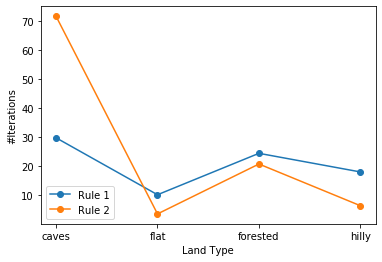

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(rule1_iterations)
df = pd.DataFrame(columns=['dim','rule', 'land','iteration'])
for i in range (len(rule1_iterations)):
  listOfSeries = [pd.Series([str(rule1_iterations[i][0]),"rule1",str(rule1_iterations[i][1]),int(rule1_iterations[i][2])], index=df.columns ) ]
  df = df.append(listOfSeries , ignore_index=True)
  listOfSeries = [pd.Series([str(rule1_iterations[i][0]),"rule2",str(rule2_iterations[i][1]),int(rule2_iterations[i][2])], index=df.columns ) ]
  df = df.append(listOfSeries , ignore_index=True)
      # Pass a list of series to the append() to add multiple rows
df['iteration'] = df['iteration'].astype(int)
rule1_df = df[df['rule'] == "rule1"]
rule2_df = df[df['rule'] == "rule2"]
rule1_df=rule1_df['iteration'].groupby([rule1_df['land']]).mean().to_frame(name='mean').reset_index()
rule2_df=rule2_df['iteration'].groupby([rule2_df['land']]).mean().to_frame(name='mean').reset_index()
plt.plot(rule1_df["land"], rule1_df["mean"], marker = 'o', label = "Rule 1")
plt.plot(rule2_df["land"], rule2_df["mean"], marker = 'o', label = "Rule 2")
      
plt.xlabel("Land Type")
plt.ylabel("#Iterations")
plt.legend(['Rule 1', 'Rule 2'], loc='lower left')
plt.show()
plt.close()

found 35 in  2
found 40 in  2
found 43 in  2
found 63 in  2
found 49 in  3
found 102 in  3
found 35 in  3
found 142 in  3
found 52 in  2
found 38 in  2
found 11 in  2
found 31 in  2
found 51 in  3
found 117 in  3
found 61 in  3
found 157 in  3
found 45 in  1
found 18 in  1
found 18 in  1
found 19 in  1
found 29 in  1
found 14 in  1
found 46 in  1
found 25 in  1
found 51 in  2
found 49 in  2
found 20 in  2
found 45 in  2
found 33 in  1
found 15 in  1
found 16 in  1
found 9 in  1
found 1 in  3
found 109 in  3
found 17 in  3
found 96 in  3
found 50 in  2
found 41 in  2
found 49 in  2
found 68 in  2
found 34 in  3
found 138 in  3
found 98 in  3
found 141 in  3
found 54 in  3
found 110 in  3
found 79 in  3
found 152 in  3
found 45 in  3
found 127 in  3
found 22 in  3
found 118 in  3
found 25 in  2
found 36 in  2
found 5 in  2
found 60 in  2
found 39 in  2
found 41 in  2
found 38 in  2
found 27 in  2
found 10 in  2
found 31 in  2
found 30 in  2
found 31 in  2
found 42 in  0
found 9 in  0
fou

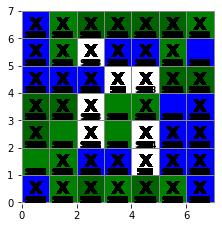

In [0]:
if __name__ == '__main__':
      rule1_iterations=[]
      rule2_iterations=[]

      rule1_with_dist_iterations=[]
      rule2_with_dist_iterations=[]

      terrain=["flat","hilly","forested","caves"]
      dim=7
      interat=0
      ms=SearchDestroy(dim, dim)
      ms.RefreshBoard()
      while interat<100:
        k,l=ms.get_target()
        land=terrain[ms.landscapes[k][l]]
        ms.Agent("rule1")
        rule1_iterations.append((land,ms.interations))
        ms.Agent("rule2")
        rule2_iterations.append((land,ms.interations))

        ms.Agent("rule1",1)
        rule1_with_dist_iterations.append((land,ms.interations))
        ms.Agent("rule2",1)
        rule2_with_dist_iterations.append((land,ms.interations))
        #ms=SearchDestroy(dim, dim)
        #ms.RefreshBoard()
        ms.SetTarget()
        interat=interat+1

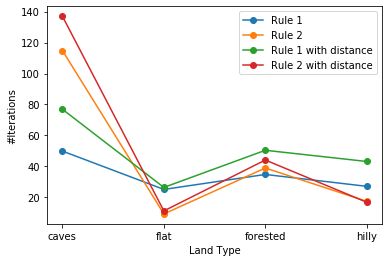

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(rule1_iterations)
df = pd.DataFrame(columns=['rule', 'land','iteration'])
for i in range (len(rule1_iterations)):
  listOfSeries = [pd.Series(["rule1",str(rule1_iterations[i][0]),int(rule1_iterations[i][1])], index=df.columns ) ]
  df = df.append(listOfSeries , ignore_index=True)
  listOfSeries = [pd.Series(["rule2",str(rule2_iterations[i][0]),int(rule2_iterations[i][1])], index=df.columns ) ]
  df = df.append(listOfSeries , ignore_index=True)

  listOfSeries = [pd.Series(["rule1 with distance",str(rule1_with_dist_iterations[i][0]),int(rule1_with_dist_iterations[i][1])], index=df.columns ) ]
  df = df.append(listOfSeries , ignore_index=True)
  listOfSeries = [pd.Series(["rule2 with distance",str(rule2_with_dist_iterations[i][0]),int(rule2_with_dist_iterations[i][1])], index=df.columns ) ]
  df = df.append(listOfSeries , ignore_index=True)
      # Pass a list of series to the append() to add multiple rows
df['iteration'] = df['iteration'].astype(int)
rule1_df = df[df['rule'] == "rule1"]
rule2_df = df[df['rule'] == "rule2"]

rule1_with_dist_df = df[df['rule'] == "rule1 with distance"]
rule2_with_dist_df = df[df['rule'] == "rule2 with distance"]

rule1_df=rule1_df['iteration'].groupby([rule1_df['land']]).mean().to_frame(name='mean').reset_index()
rule2_df=rule2_df['iteration'].groupby([rule2_df['land']]).mean().to_frame(name='mean').reset_index()
plt.plot(rule1_df["land"], rule1_df["mean"], marker = 'o', label = "Rule 1")
plt.plot(rule2_df["land"], rule2_df["mean"], marker = 'o', label = "Rule 2")


rule1_with_dist_df=rule1_with_dist_df['iteration'].groupby([rule1_with_dist_df['land']]).mean().to_frame(name='mean').reset_index()
rule2_with_dist_df=rule2_with_dist_df['iteration'].groupby([rule2_with_dist_df['land']]).mean().to_frame(name='mean').reset_index()
plt.plot(rule1_with_dist_df["land"], rule1_with_dist_df["mean"], marker = 'o', label = "Rule 1 with distance")
plt.plot(rule2_with_dist_df["land"], rule2_with_dist_df["mean"], marker = 'o', label = "Rule 2 with distance")
      
plt.xlabel("Land Type")
plt.ylabel("#Iterations")
plt.legend(['Rule 1', 'Rule 2','Rule 1 with distance','Rule 2 with distance'], loc='best')
plt.show()
plt.close()